In [73]:
import random
import os
import xml.etree.ElementTree as ET
from collections import Counter
import math
from lib_vhdl_gen import *
from lib_CSTasks import *
import warnings

import json
import argparse
import networkx as nx

import matplotlib.pyplot as plt

from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable , LpMinimize ,PULP_CBC_CMD ,SCIP_CMD,SCIP_PY

def LinProResult(task_to_node):
    from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable , LpMinimize
    # Create the model
    model = LpProblem(name='small-problem', sense=LpMinimize)

    t_comp=LpVariable(name='t_comp', lowBound=0)

    #######################################################################################################
    # Create random mapping and according cs paths for all connections
    #######################################################################################################

    cs_path_list=[]
    num_tasks = 20  # Total tasks
    num_nodes = 15   # Total nodes

    # DO NOT SET RANDOM NODES
    # task_to_node = assign_nodes_to_tasks_unique(num_tasks, num_nodes)

    memory_router=25
    flits_per_packet=31 # (31 data + 1 header)

    map_additional_path="/home/sfischer/Documents/projects/wk_hybridNoC_VHDL/Python/gen_vhdl_from_task/map_addition.xml"

    for i in task_to_node:
        if i%2==1 and task_to_node.get(i+1)!=None:
            cs_path_list.append((task_to_node.get(i),task_to_node.get(i+1)))


    xml_file = "/home/sfischer/Documents/projects/wk_hybridNoC_VHDL/Python/gen_vhdl_from_task/map.xml"  # Input XML file
    output_file = "/home/sfischer/Documents/projects/wk_hybridNoC_VHDL/Python/gen_vhdl_from_task/map.xml"  # Output XML file


    update_xml_map(xml_file, task_to_node, output_file)


    # cs_path_list=[(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10)]
    cs_data_xml,cs_task_xml,cs_map_xml,dest_address_list_int=cs_tasks(source_destination = cs_path_list, start_task=30, start_PE=16)
    cs_task_xml=""
    ps_link_width=32
    cs_link_width=80

    #######################################################################################################
    # Add the new tasks and mapping of the cs configure tasks to the xml files/xml strings and read files
    #######################################################################################################


    with open('/home/sfischer/Documents/projects/wk_hybridNoC_VHDL/Python/gen_vhdl_from_task/data.xml', 'r') as file:
        data_xml = file.read()

    closing_tag_position = data_xml.rfind('</tasks>')  # Find the position of the closing </tasks>
    if closing_tag_position != -1:
        # Insert the new_line before </tasks>
        data_xml = data_xml[:closing_tag_position] + '\n' + cs_task_xml + '\n' + data_xml[closing_tag_position:]

    tree = ET.ElementTree(ET.fromstring(data_xml))
    root = tree.getroot()


    with open('/home/sfischer/Documents/projects/wk_hybridNoC_VHDL/Python/gen_vhdl_from_task/map.xml', 'r') as file:
        map_xml = file.read()

    closing_tag_position2 = map_xml.rfind('</map>')
    if closing_tag_position2 != -1:
        map_xml = map_xml[:closing_tag_position2] + '\n' + cs_map_xml + '\n' + map_xml[closing_tag_position2:]

    tree_map = ET.ElementTree(ET.fromstring(map_xml))
    root_map = tree_map.getroot()


    tasks=root.findall('tasks')[0]



    #######################################################################################################
    # Go through map file and extract the mappings and create a list of number of mapped tasks to PEs
    #######################################################################################################
    PE_task_pairs = [] # pair of all tasks and their PE
    for bind in root_map.findall('bind'):
        task_value = bind.find('task').get('value')
        PE_value = bind.find('node').get('value')
        
        PE_task_pairs.append((int(PE_value), int(task_value)))

    Task_init_num=len(PE_task_pairs) #number of tasks in the data.xml file


    PE_values = [PE for PE, task2 in PE_task_pairs] #list of just PEs
    PE_count = Counter(PE_values) #count how often PEs appear in data.xml file

    PE_count_start = {key: 0 for key in range(len(PE_count)+50)} # dict of each PE init with 0 to count how many destinations are created with that PE later one

    for PE, count in PE_count.items():
        if count>50:
            raise ValueError("Not implemented more than 50 task per note yet")

    #######################################################################################################
    # Create a list of all tasks from the data.xml file
    #######################################################################################################
    delay_comp_send_total=0
    connection_num=0

    Task_list=[] # list of all tasks objects
    start_task_list=[]

    for task2 in tasks.findall('task'): # iterate through all tasks in data.xml
        dst_element_send_list={}
        destinations=task2.find('generates').find('possibility').find('destinations').findall('destination')
        if len(destinations)==0:
            consume_task=True
        else:
            consume_task=False
            delay=destinations[0].find('delay').get('max')

        requires = task2.find('requires')


        Task_num=task2.get('id')
        if requires is not None:
            sources = requires.findall('requirement')
        else:
            start_task_list.append(int(Task_num))

        repetition=task2.find('repeat').get('min')
        dest_num=len(destinations)
        src_num=len(sources)

        for dest in destinations:
            dst_element_send_list[int(dest.find('task').get('value'))]=int(dest.find('count').get('max'))


        PE_for_task = next((PE for PE, task2 in PE_task_pairs if task2 == int(Task_num)), None) #PE for the task 'Task_num'
        
        if src_num>5:
            raise ValueError("more then 50 source of a task are not implemented yet")
        if src_num==0:
            raise ValueError("generator task with no source not implemented yet")
        
        dst_element_list=[]
        dst_task_list=[]
        snd_out_list=[]
        for j in destinations:
            dst_task_list.append(int(j.find('task').get('value')))
            for pair in PE_task_pairs:
                if int(j.find('task').get('value'))==pair[1]:

                    #Only the configuration (delay==-1) task youse the destination task in the data.xml file as the router number and not the destination number
                    if delay=="-1":
                        dst_element_list.append(pair[1])
                    else:
                        dst_element_list.append(pair[0])
            snd_out_list.append(j.find('count').get('max'))

        if len(dst_element_list)==1:
            dst_element_list.append(None)
            snd_out_list.append(None)        

        req_flits_list=[]
        src_task_list=[]
        src_type_list=[]
        for n in sources:
            req_flits_list.append(n.find('count').get('max'))
            src_task_list.append(n.find('source').get('value'))
            src_type_list.append(n.find('type').get('value'))

        req_flits_list.append(None)
        src_task_list.append(None)        

    ###########################################################################################################################
    # create linear programming constrains
    ###########################################################################################################################

        time_per_flit=0.649
        flit_number=0
        repetitions=10
        max_task_num=20

        # 24 as a factor for delay of mem data per flit is tested to be the most accurate
        mem_delay=(len(xyz_routing(int(Task_num),memory_router))-1)*24+math.ceil(task2memory_bits(Task_num,map_additional_path)/flits_per_packet)+2
        if len(snd_out_list) > 0:
            flit_number=snd_out_list[0]

        if int(Task_num) % 2!=0 and connection_num<len(dest_address_list_int):
            flit_delay=math.ceil(int(flit_number)*time_per_flit*(ps_link_width/cs_link_width)*(len(dest_address_list_int[connection_num])-1))
            connection_num+=1
        else:
            flit_delay=0



        delay_comp_send=int(delay)+flit_delay+mem_delay
        delay_comp=int(delay)+mem_delay
        delay_send=flit_delay
        delay_comp_send_total+=delay_comp_send

        # create variables
        exec(f"t{Task_num}_0 = LpVariable(name='t{Task_num}_0', lowBound=0)",locals())
       
        temp_str=f"t_comp_{Task_num} = LpVariable(name='t_comp_{Task_num}', lowBound=0)"
        send_str=f"t_send_{Task_num} = LpVariable(name='t_send_{Task_num}', lowBound=0)"
     
        exec(temp_str,locals())
        exec(send_str,locals())

        # set static constraints for comp and send time
        exec(f"model += (t_comp_{Task_num} == {delay_comp}, 'constraint_t_comp_{Task_num}')",locals())
        exec(f"model += (t_send_{Task_num} == {delay_send}, 'constraint_t_send_{Task_num}')",locals())


        src_task_list_filtered = [x for x in src_task_list if x is not None]

        # task constraints for first repetition
        for i in src_task_list_filtered:
            if int(i)<int(Task_num):
                exec(f"model += (t{i}_0 + t_comp_{Task_num} + t_send_{Task_num} <= t{Task_num}_0, 'constraint_T{Task_num}_{i}_0')",locals())

        # task constraints for rest of repetitions
        for m in range(repetitions-1):
            exec(f"t{Task_num}_{m+1} = LpVariable(name='t{Task_num}_{m+1}', lowBound=0)",locals())
            for i in src_task_list_filtered:
                if int(i)<int(Task_num):
                    exec(f"model += (t{i}_{m+1} + t_comp_{Task_num} + t_send_{Task_num}<= t{Task_num}_{m+1}, 'constraint_T{Task_num}_{i}_{m+1}')",locals())

    # constraints for multi use of links
    multi_pair_list=count_consecutive_pairs_no_file(dest_address_list_int)
    for multi_pair in multi_pair_list:
        index_list=find_pair_indices(multi_pair,dest_address_list_int)
        for index in range(len(index_list)):
            prev_idx=index_list[index-1]*2+1
            if index+1>len(index_list)-1:
                next_idx=index_list[0]*2+1
            else:
                next_idx=index_list[index+1]*2+1
            curr_idx=index_list[index]*2+1
            last_idx=index_list[-1]*2+1

            # print(f"index_list: {index_list} curr_idx: {curr_idx} prev_idx: {prev_idx} next_idx: {next_idx} ")

            for m in range(repetitions-1):
                constraint_name = f"constraint_MultiLink{curr_idx}_{prev_idx}_{m+1}"
                if constraint_name not in model.constraints:
                    if last_idx!=prev_idx:
                        prev_rep=m+1
                    else:
                        prev_rep=m
                    exec(f"model += (t{prev_idx}_{prev_rep} + t_send_{curr_idx} <= t{curr_idx}_{m+1}, '{constraint_name}')",locals())




    # constraint: first task in accel can only start when last task is done + last task in accel can only start when first task of next accel is done. Here hardcoded as always two tasks in accel
    for Task_num in range(max_task_num-2):
        for m in range(repetitions-1):
            exec(f"model += (t{int(Task_num)+1}_{m} + t_comp_{Task_num} + t_send_{Task_num} <= t{Task_num}_{m+1}, 'constraint_Task{Task_num}_{int(Task_num)+1}_{m+1}')",locals())


    # constraints of first task
    exec("model += (t_comp_0 <= t0_0, 'constraint_0_0_0')",locals())

    # objective
    exec("model += t18_9",locals())

    # print("CONSTRAINT LENGTH")
    print(model)

    status = model.solve()


    # for var in model.variables():
    #     print(f"{var.name} = {var.varValue}")

    print(f"objective: {model.objective.value()}")
    return(model.objective.value())



In [74]:

def CreateNetworkXGraph(task_to_node={0: 12, 1: 12, 2: 2, 3: 2, 4: 14, 5: 14, 6: 7, 7: 7, 8: 13, 9: 13, 10: 1, 11: 1, 12: 3, 13: 3, 14: 10, 15: 10, 16: 4, 17: 4, 18: 8, 19: 8},detailed=False,Figure=False,flit_delay_consistent=False):
    #######################################################################################################
    # Create random mapping and according cs paths for all connections
    #######################################################################################################

    cs_path_list=[]
    num_tasks = 20  # Total tasks
    num_nodes = 15   # Total nodes

    # DO NOT SET RANDOM NODES
    # task_to_node = assign_nodes_to_tasks_unique(num_tasks, num_nodes)

    memory_router=25
    flits_per_packet=31 # (31 data + 1 header)

    map_additional_path="/home/sfischer/Documents/projects/wk_AI2Task/ReWrite/map_addition.xml"

    for i in task_to_node:
        if i%2==1 and task_to_node.get(i+1)!=None:
            cs_path_list.append((task_to_node.get(i),task_to_node.get(i+1)))

    cs_data_xml,cs_task_xml,cs_map_xml,dest_address_list_int=cs_tasks(source_destination = cs_path_list,
                                                start_task=30,
                                                start_PE=16
                                                )
    cs_task_xml=""
    ps_link_width=32
    cs_link_width=80

    #######################################################################################################
    # Add the new tasks and mapping of the cs configure tasks to the xml files/xml strings and read files
    #######################################################################################################


    with open('/home/sfischer/Documents/projects/wk_hybridNoC_VHDL/Python/gen_vhdl_from_task/data.xml', 'r') as file:
        data_xml = file.read()

    closing_tag_position = data_xml.rfind('</tasks>')  # Find the position of the closing </tasks>
    if closing_tag_position != -1:
        # Insert the new_line before </tasks>
        data_xml = data_xml[:closing_tag_position] + '\n' + cs_task_xml + '\n' + data_xml[closing_tag_position:]

    tree = ET.ElementTree(ET.fromstring(data_xml))
    root = tree.getroot()

    tasks=root.findall('tasks')[0]

    #######################################################################################################
    # Create a list of all tasks from the data.xml file
    #######################################################################################################
    connection_num=0
    start_task_list=[]
    G = nx.DiGraph()
    first=True
    last =tasks.findall('task')[-1]
    last_true=False
    for task2 in tasks.findall('task'): # iterate through all tasks in data.xml

        if last==task2:
            last_true=True
        dst_element_send_list={}
        destinations=task2.find('generates').find('possibility').find('destinations').findall('destination')
        if len(destinations)==0:
            consume_task=True
        else:
            consume_task=False
            delay=destinations[0].find('delay').get('max')

        requires = task2.find('requires')


        Task_num=task2.get('id')
        if requires is not None:
            sources = requires.findall('requirement')
        else:
            start_task_list.append(int(Task_num))

        src_num=len(sources)

        for dest in destinations:
            dst_element_send_list[int(dest.find('task').get('value'))]=int(dest.find('count').get('max'))

        dst_element_list=[]
        dst_task_list=[]
        snd_out_list=[]
        for j in destinations:
            dst_task_list.append(int(j.find('task').get('value')))
            snd_out_list.append(j.find('count').get('max'))

        if len(dst_element_list)==1:
            dst_element_list.append(None)
            snd_out_list.append(None)        

        req_flits_list=[]
        src_task_list=[]
        src_type_list=[]
        for n in sources:
            req_flits_list.append(n.find('count').get('max'))
            src_task_list.append(n.find('source').get('value'))
            src_type_list.append(n.find('type').get('value'))

        req_flits_list.append(None)
        src_task_list.append(None)        

    ###########################################################################################################################
    # create NetworkX Graph
    ###########################################################################################################################

        time_per_flit=0.649 # for 1 hop
        flit_number=0
        repetitions=10
        max_task_num=20

        if detailed==True:
            # 24 as a factor for delay of mem data per flit is tested to be the most accurate
            mem_delay=(len(xyz_routing(int(Task_num),memory_router))-1)*24+math.ceil(task2memory_bits(Task_num,map_additional_path)/flits_per_packet)+2
            if len(snd_out_list) > 0:
                flit_number=snd_out_list[0]

            if int(Task_num) % 2!=0 and connection_num<len(dest_address_list_int):
                flit_delay=math.ceil(int(flit_number)*time_per_flit*(ps_link_width/cs_link_width)*(len(dest_address_list_int[connection_num])-1))
                connection_num+=1
            else:
                flit_delay=0
                # if flit_delay_consistent==False:
                #     flit_delay=0
                # else:
                #     flit_delay=math.ceil(int(flit_number)*time_per_flit*(ps_link_width/cs_link_width)*(len(dest_address_list_int[connection_num])-1))


            delay_comp=int(delay)
            delay_mem=mem_delay
            delay_send=flit_delay
        else:
            
            # simplified memory delay without taking distance to memory into account 
            mem_delay=math.ceil(task2memory_bits(Task_num,map_additional_path))

            # simplified flit delay, without taking distance and time for distance into account
            if len(snd_out_list) > 0:
                flit_number=snd_out_list[0]
                flit_delay=math.ceil(int(flit_number)*(ps_link_width/cs_link_width))

            delay_comp=int(delay)
            delay_send=flit_delay
            delay_mem=mem_delay


    
        G.add_node(int(Task_num),delay_comp=delay_comp,delay_mem=delay_mem,delay_send=delay_send,src=first,dst=last_true)
        first=False
        src_task_list_filtered = [x for x in src_task_list if x is not None]

        # task constraints for first repetition
        for idx,i in enumerate(src_task_list_filtered):
            if int(i)<int(Task_num):
                G.add_edge(int(i),int(Task_num),flits=math.ceil(int(req_flits_list[idx])*(ps_link_width/cs_link_width)))

    # for node in G.nodes:
    #     print(f"Node {node} -> Edges: {list(G.predecessors(node))}, node delay_comp ={G.nodes[node]["delay_comp"]}")

    # print(G.nodes[1]["delay_comp"])

    if Figure==True:
        plt.figure(figsize=(5, 5))
        pos = nx.spring_layout(G)  # Layout for positioning
        nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="black", arrows=True, node_size=800, font_size=12)

        # Draw edge labels (flits)
        edge_labels = {(u, v): f"{d['flits']} flits" for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        plt.show()

    
    return(G)

# print(CreateNetworkXGraph())
# draw_networkx_graph(CreateNetworkXGraph())

In [75]:

# get path for the connections based on mapping
def getPaths(task_to_node):
    cs_path_list=[]
    for i in task_to_node:
        if i%2==1 and task_to_node.get(i+1)!=None:
            cs_path_list.append((task_to_node.get(i),task_to_node.get(i+1)))

    cs_data_xml,cs_task_xml,cs_map_xml,dest_address_list_int=cs_tasks(source_destination = cs_path_list, start_task=30, start_PE=16)
    return(dest_address_list_int)


In [76]:
G=CreateNetworkXGraph(detailed=False ,Figure=False) 

print("Node Attributes:")
for node, attrs in G.nodes(data=True):
    print(f"Node {node}: {attrs}")


print(task2memory_bits(0,"/home/sfischer/Documents/projects/wk_AI2Task/ReWrite/map_addition.xml"))

Node Attributes:
Node 0: {'delay_comp': 4, 'delay_mem': 1078, 'delay_send': 285, 'src': True, 'dst': False}
Node 1: {'delay_comp': 34, 'delay_mem': 38, 'delay_send': 277, 'src': False, 'dst': False}
Node 2: {'delay_comp': 67, 'delay_mem': 75, 'delay_send': 554, 'src': False, 'dst': False}
Node 3: {'delay_comp': 1, 'delay_mem': 0, 'delay_send': 137, 'src': False, 'dst': False}
Node 4: {'delay_comp': 50, 'delay_mem': 223, 'delay_send': 205, 'src': False, 'dst': False}
Node 5: {'delay_comp': 0, 'delay_mem': 0, 'delay_send': 342, 'src': False, 'dst': False}
Node 6: {'delay_comp': 10, 'delay_mem': 42, 'delay_send': 137, 'src': False, 'dst': False}
Node 7: {'delay_comp': 47, 'delay_mem': 223, 'delay_send': 194, 'src': False, 'dst': False}
Node 8: {'delay_comp': 10, 'delay_mem': 42, 'delay_send': 137, 'src': False, 'dst': False}
Node 9: {'delay_comp': 26, 'delay_mem': 116, 'delay_send': 137, 'src': False, 'dst': False}
Node 10: {'delay_comp': 26, 'delay_mem': 116, 'delay_send': 137, 'src': Fa

In [77]:

# create the linear programming model based on a networkX graph and mapping for the overlapping connections
def Graph2LinProgStaticMap():
    from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable , LpMinimize
    repetitions=10

    model = LpProblem(name='small-problem', sense=LpMinimize)

    G=CreateNetworkXGraph({0: 12, 1: 12, 2: 2, 3: 2, 4: 14, 5: 14, 6: 7, 7: 7, 8: 13, 9: 13, 10: 1, 11: 1, 12: 3, 13: 3, 14: 10, 15: 10, 16: 4, 17: 4, 18: 8, 19: 8},True ,Figure=False)
    dest_address_list_int=getPaths({0: 12, 1: 12, 2: 2, 3: 2, 4: 14, 5: 14, 6: 7, 7: 7, 8: 13, 9: 13, 10: 1, 11: 1, 12: 3, 13: 3, 14: 10, 15: 10, 16: 4, 17: 4, 18: 8, 19: 8})

    for task, atr in G.nodes(data=True):

        # Define Variables
        exec(f"t{task}_0 = LpVariable(name='t{task}_0', lowBound=0)",locals())
        exec(f"t_comp_{task} = LpVariable(name='t_comp_{task}', lowBound=0)",locals())
        exec(f"t_send_{task} = LpVariable(name='t_send_{task}', lowBound=0)",locals())
        exec(f"t_mem_{task} = LpVariable(name='t_mem_{task}', lowBound=0)",locals())

        # Add static time constraints
        exec(f"model += (t_comp_{task} == {atr['delay_comp']}, 'constraint_t_comp_{task}')",locals())
        exec(f"model += (t_send_{task} == {atr['delay_send']}, 'constraint_t_send_{task}')",locals())
        exec(f"model += (t_mem_{task} == {atr['delay_mem']}, 'constraint_t_mem_{task}')",locals())

        predecessors = list(G.predecessors(task))
        print(predecessors)

        # set predecessor constraints
        for pre in predecessors:
            exec(f"model += (t{pre}_0 + t_comp_{task} + t_send_{task} + t_mem_{task} <= t{task}_0, 'constraint_T{task}_{pre}_0')",locals())

        # set predecessor constraints for repetition tasks
        for m in range(repetitions-1):
            exec(f"t{task}_{m+1} = LpVariable(name='t{task}_{m+1}', lowBound=0)",locals())
            for pre in predecessors:
                if int(pre)<int(task):
                    exec(f"model += (t{pre}_{m+1} + t_comp_{task} + t_send_{task} + t_mem_{task} <= t{task}_{m+1}, 'constraint_T{task}_{pre}_{m+1}')",locals())

    # constraint: first task in accel can only start when last task is done + last task in accel can only start when first task of next accel is done. Here hardcoded as always two tasks in accel
    for Task_num in range(G.number_of_nodes()-2):
        for m in range(repetitions-1):
            exec(f"model += (t{int(Task_num)+1}_{m} + t_comp_{Task_num} + t_send_{Task_num} + t_mem_{Task_num} <= t{Task_num}_{m+1}, 'constraint_Task{Task_num}_{int(Task_num)+1}_{m+1}')",locals())


    # constraints for multi use of links
    multi_pair_list=count_consecutive_pairs_no_file(dest_address_list_int)
    for multi_pair in multi_pair_list:
        index_list=find_pair_indices(multi_pair,dest_address_list_int)
        for index in range(len(index_list)):
            prev_idx=index_list[index-1]*2+1
            if index+1>len(index_list)-1:
                next_idx=index_list[0]*2+1
            else:
                next_idx=index_list[index+1]*2+1
            curr_idx=index_list[index]*2+1
            last_idx=index_list[-1]*2+1

            # print(f"index_list: {index_list} curr_idx: {curr_idx} prev_idx: {prev_idx} next_idx: {next_idx} ")

            for m in range(repetitions-1):
                constraint_name = f"constraint_MultiLink{curr_idx}_{prev_idx}_{m+1}"
                if constraint_name not in model.constraints:
                    if last_idx!=prev_idx:
                        prev_rep=m+1
                    else:
                        prev_rep=m
                    exec(f"model += (t{prev_idx}_{prev_rep} + t_send_{curr_idx} <= t{curr_idx}_{m+1}, '{constraint_name}')",locals())




    # separat constrain for first task
    exec("model += (t_comp_0 +t_mem_0<= t0_0, 'constraint_0_0_0')",locals())

    # objective function
    exec("model += t18_9",locals())

    status = model.solve()
    print(f"objective: {model.objective.value()}")




In [78]:

def Graph2LinProgStaticMapDict():
    repetitions = 10

    model = LpProblem(name='small-problem', sense=LpMinimize)

    G = CreateNetworkXGraph({0: 12, 1: 12, 2: 2, 3: 2, 4: 14, 5: 14, 6: 7, 7: 7, 8: 13, 9: 13, 10: 1, 11: 1, 12: 3, 13: 3, 14: 10, 15: 10, 16: 4, 17: 4, 18: 8, 19: 8}, detailed=False, Figure=False)
    dest_address_list_int = getPaths({0: 12, 1: 12, 2: 2, 3: 2, 4: 14, 5: 14, 6: 7, 7: 7, 8: 13, 9: 13, 10: 1, 11: 1, 12: 3, 13: 3, 14: 10, 15: 10, 16: 4, 17: 4, 18: 8, 19: 8})

    task_vars = {}  # Dictionary to hold variables for each task
    task_constraints = []  # List to collect constraints for later addition to the model

    # Define Variables and Constraints for each task
    for task, atr in G.nodes(data=True):
        tR0 = LpVariable(name=f't{task}_0', lowBound=0)
        t_comp = LpVariable(name=f't_comp_{task}', lowBound=0)
        t_send = LpVariable(name=f't_send_{task}', lowBound=0)
        t_mem = LpVariable(name=f't_mem_{task}', lowBound=0)

        task_vars[task] = {'tR0': tR0, 't_comp': t_comp, 't_send': t_send, 't_mem': t_mem}

        # Static time constraints
        task_constraints.append(t_comp == atr['delay_comp'])
        task_constraints.append(t_send == atr['delay_send'])
        task_constraints.append(t_mem == atr['delay_mem'])

        predecessors = list(G.predecessors(task))

        # Predecessor constraints
        for pre in predecessors:
            task_constraints.append(task_vars[pre]['tR0'] + t_comp + t_send + t_mem <= tR0)

        # Predecessor constraints for repetition tasks
        for m in range(repetitions - 1):
            t_m = LpVariable(name=f't{task}_{m + 1}', lowBound=0)
            task_vars[task][f'tR{m + 1}'] = t_m

            for pre in predecessors:
                if int(pre) < int(task):
                    task_constraints.append(task_vars[pre][f'tR{m + 1}'] + t_comp + t_send + t_mem <= t_m)

    # Constraint for the last task in one acceleration block and the first task in the next block
    for Task_num in range(G.number_of_nodes() - 2):
        for m in range(repetitions - 1):
            task_constraints.append(task_vars[Task_num + 1][f'tR{m}'] + task_vars[Task_num]['t_comp'] + task_vars[Task_num]['t_send'] + task_vars[Task_num]['t_mem'] <= task_vars[Task_num][f'tR{m + 1}'])

    # Multi-use of links constraints
    multi_pair_list = count_consecutive_pairs_no_file(dest_address_list_int)
    for multi_pair in multi_pair_list:
        index_list = find_pair_indices(multi_pair, dest_address_list_int)
        for index in range(len(index_list)):
            prev_idx = index_list[index - 1] * 2 + 1
            if index + 1 > len(index_list) - 1:
                next_idx = index_list[0] * 2 + 1
            else:
                next_idx = index_list[index + 1] * 2 + 1
            curr_idx = index_list[index] * 2 + 1
            last_idx = index_list[-1] * 2 + 1

            for m in range(repetitions - 1):
                constraint_name = f"constraint_MultiLink{curr_idx}_{prev_idx}_{m + 1}"
                if constraint_name not in model.constraints:
                    prev_rep = m + 1 if last_idx != prev_idx else m
                    task_constraints.append(task_vars[prev_idx][f'tR{prev_rep}'] + task_vars[curr_idx]['t_send'] <= task_vars[curr_idx][f'tR{m + 1}'])

    # Add the constraints to the model
    for constraint in task_constraints:
        model += constraint

    # Constraint for first task
    model += task_vars[0]['t_comp'] + task_vars[0]['t_mem'] <= task_vars[0]['tR0']

    # Objective function
    model += task_vars[18]['tR9']

    # Solve the problem
    status = model.solve()
    print(f"objective: {model.objective.value()}")



In [79]:

def CreateNetworkXGraphManuelLinear(Figure=False):

    G = nx.DiGraph()

    # number of parallel paths
    # length of parallel paths

    ###########################################################################################################################
    # create NetworkX Graph
    ###########################################################################################################################

    time_per_flit=0.649 # for 1 hop
    flit_number=0
    repetitions=10
    max_task_num=16


    # simplified memory delay without taking distance to memory into account 
    mem_delay=100
    flit_delay=10
    delay_comp=100

    delay_send=flit_delay
    delay_mem=mem_delay


    for i in range(max_task_num):
        G.add_node(i,delay_comp=delay_comp,delay_mem=delay_mem,delay_send=delay_send)
        if i >0:
            G.add_edge(i-1,i)
            G.add_edge(i-1,i,flits=flit_delay)


    # for node in G.nodes:
    #     print(f"Node {node} -> Edges: {list(G.predecessors(node))}, node delay_comp ={G.nodes[node]["delay_comp"]}")

    # print(G.nodes[1]["delay_comp"])

    if Figure==True:
        plt.figure(figsize=(5, 5))
        pos = nx.spring_layout(G)  # Layout for positioning
        nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="black", arrows=True, node_size=800, font_size=12)

        # Draw edge labels (flits)
        edge_labels = {(u, v): f"{d['flits']} flits" for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        plt.show()

    return(G)


In [80]:


from LinProg_lib import *
# Initialize graph
G = CreateNetworkXGraphManuelParallel()
# elements = graph_to_cytoscape(G)

# # Dash App
# app = dash.Dash(__name__)

# app.layout = html.Div([
#     html.H3("Drag and Move Nodes in Real Time"),
#     cyto.Cytoscape(
#         id="cytoscape-graph",
#         elements=elements,
#         layout={"name": "preset"},  # Use preset positions
#         style={"width": "100%", "height": "600px"},
#         stylesheet=[
#             {"selector": "node", "style": {
#                 "content": "data(label)",
#                 "background-color": "lightblue",
#                 "width": "75px",  # Increase node size
#                 "height": "75px",  # Increase node size
#                 "font-size": "16px",  # Make labels larger
#                 "text-valign": "center",
#             }},
#             {"selector": "edge", "style": {
#                 "curve-style": "bezier",
#                 "target-arrow-shape": "triangle",
#                 "label": "data(label)",
#                 "font-size": "12px",
#                 "color": "white",  # Make edge labels white
#             }}
#         ],
#     ),
# ])

# if __name__ == "__main__":
#     app.run(debug=True)

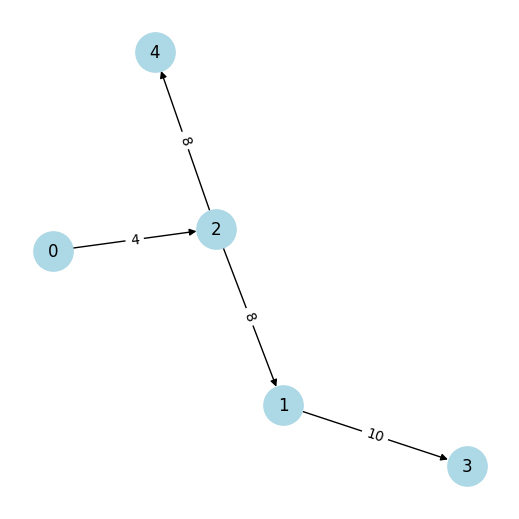

In [81]:

import random
def CreateNetworkXGraphRandom(Figure=False, nodes=5):
    G = nx.DiGraph()  # Directed graph
    G.add_nodes_from(range(nodes))  # Add nodes 0 to n-1

    # Add random delays as node attributes
    for node in range(nodes):
        delay_comp = random.randint(1, 100)  # Random integer for delay_comp
        delay_mem = random.randint(1, 10)   # Random integer for delay_mem
        delay_send = random.randint(1, 10)  # Random integer for delay_send
        
        # Add node with attributes
        G.nodes[node]['delay_comp'] = delay_comp
        G.nodes[node]['delay_mem'] = delay_mem
        G.nodes[node]['delay_send'] = delay_send

    # Ensure source node (node 0) has no incoming edges
    # and destination node (node nodes-1) has no outgoing edges
    # Source connects to at least one other node
    first_hop = random.randint(1, nodes-2)
    G.add_edge(0, first_hop, flits=G.nodes[0]['delay_send'])

    # Intermediate random edges, avoiding self-loops, bidirectional edges, and cycles
    for node in range(1, nodes-1):  # Exclude source and destination
        target = random.randint(1, nodes-1)
        while target == node or G.has_edge(target, node) or G.has_edge(node, target):  # Avoid self-loops and bidirectional edges
            target = random.randint(1, nodes-1)
        
        # Temporarily add the edge to check for cycles
        G.add_edge(node, target, flits=G.nodes[node]['delay_send'])
        
        # Check if adding this edge creates a cycle
        if nx.is_directed_acyclic_graph(G) == False:  # Checks if the graph has a cycle
            G.remove_edge(node, target)  # Remove the edge if it creates a cycle
        else:
            # Keep the edge if no cycle is detected
            pass

    # Ensure at least one path to the destination
    prev_node = random.randint(1, nodes-2)
    G.add_edge(prev_node, nodes-1, flits=G.nodes[prev_node]['delay_send'])

    # Ensure destination node (nodes-1) has no outgoing edges
    G.remove_edges_from(list(G.out_edges(nodes-1)))


    if Figure==True:
        plt.figure(figsize=(5, 5))
        pos = nx.spring_layout(G)  # Layout for positioning
        nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="black", arrows=True, node_size=800, font_size=12)

        # Draw edge labels (flits)
        edge_labels = {(u, v): f"{d['flits']}" for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        plt.show()

    return(G)

CreateNetworkXGraphRandom(True)

In [82]:
G=CreateNetworkXGraph()
# Print all attributes of the nodes
print("Node Attributes:")
for node, attrs in G.nodes(data=True):
    print(f"Node {node}: {attrs}")

# Print all attributes of the edges
print("\nEdge Attributes:")
for u, v, attrs in G.edges(data=True):
    print(f"Edge from {u} to {v}: {attrs}")


G=CreateNetworkXGraphManuelParallel()
# Print all attributes of the nodes
print("Node Attributes:")
for node, attrs in G.nodes(data=True):
    print(f"Node {node}: {attrs}")

# Print all attributes of the edges
print("\nEdge Attributes:")
for u, v, attrs in G.edges(data=True):
    print(f"Edge from {u} to {v}: {attrs}")

Node Attributes:
Node 0: {'delay_comp': 4, 'delay_mem': 1078, 'delay_send': 285, 'src': True, 'dst': False}
Node 1: {'delay_comp': 34, 'delay_mem': 38, 'delay_send': 277, 'src': False, 'dst': False}
Node 2: {'delay_comp': 67, 'delay_mem': 75, 'delay_send': 554, 'src': False, 'dst': False}
Node 3: {'delay_comp': 1, 'delay_mem': 0, 'delay_send': 137, 'src': False, 'dst': False}
Node 4: {'delay_comp': 50, 'delay_mem': 223, 'delay_send': 205, 'src': False, 'dst': False}
Node 5: {'delay_comp': 0, 'delay_mem': 0, 'delay_send': 342, 'src': False, 'dst': False}
Node 6: {'delay_comp': 10, 'delay_mem': 42, 'delay_send': 137, 'src': False, 'dst': False}
Node 7: {'delay_comp': 47, 'delay_mem': 223, 'delay_send': 194, 'src': False, 'dst': False}
Node 8: {'delay_comp': 10, 'delay_mem': 42, 'delay_send': 137, 'src': False, 'dst': False}
Node 9: {'delay_comp': 26, 'delay_mem': 116, 'delay_send': 137, 'src': False, 'dst': False}
Node 10: {'delay_comp': 26, 'delay_mem': 116, 'delay_send': 137, 'src': Fa

In [83]:
param1 = 1
param2 = 0.1

Edge from 0 to 1: {'flits': 285}
Edge from 1 to 2: {'flits': 277}
Edge from 2 to 3: {'flits': 554}
Edge from 2 to 4: {'flits': 554}
Edge from 3 to 5: {'flits': 137}
Edge from 4 to 5: {'flits': 205}
Edge from 5 to 6: {'flits': 342}
Edge from 5 to 8: {'flits': 342}
Edge from 6 to 7: {'flits': 137}
Edge from 7 to 12: {'flits': 194}
Edge from 8 to 9: {'flits': 137}
Edge from 9 to 10: {'flits': 137}
Edge from 10 to 11: {'flits': 137}
Edge from 11 to 12: {'flits': 194}
Edge from 12 to 13: {'flits': 388}
Edge from 12 to 14: {'flits': 388}
Edge from 13 to 15: {'flits': 95}
Edge from 14 to 15: {'flits': 95}
Edge from 15 to 16: {'flits': 189}
Edge from 15 to 17: {'flits': 189}
Edge from 15 to 19: {'flits': 189}
Edge from 15 to 22: {'flits': 189}
Edge from 16 to 24: {'flits': 48}
Edge from 17 to 18: {'flits': 32}
Edge from 18 to 24: {'flits': 48}
Edge from 19 to 20: {'flits': 32}
Edge from 20 to 21: {'flits': 48}
Edge from 21 to 24: {'flits': 48}
Edge from 22 to 23: {'flits': 189}
Edge from 23 to

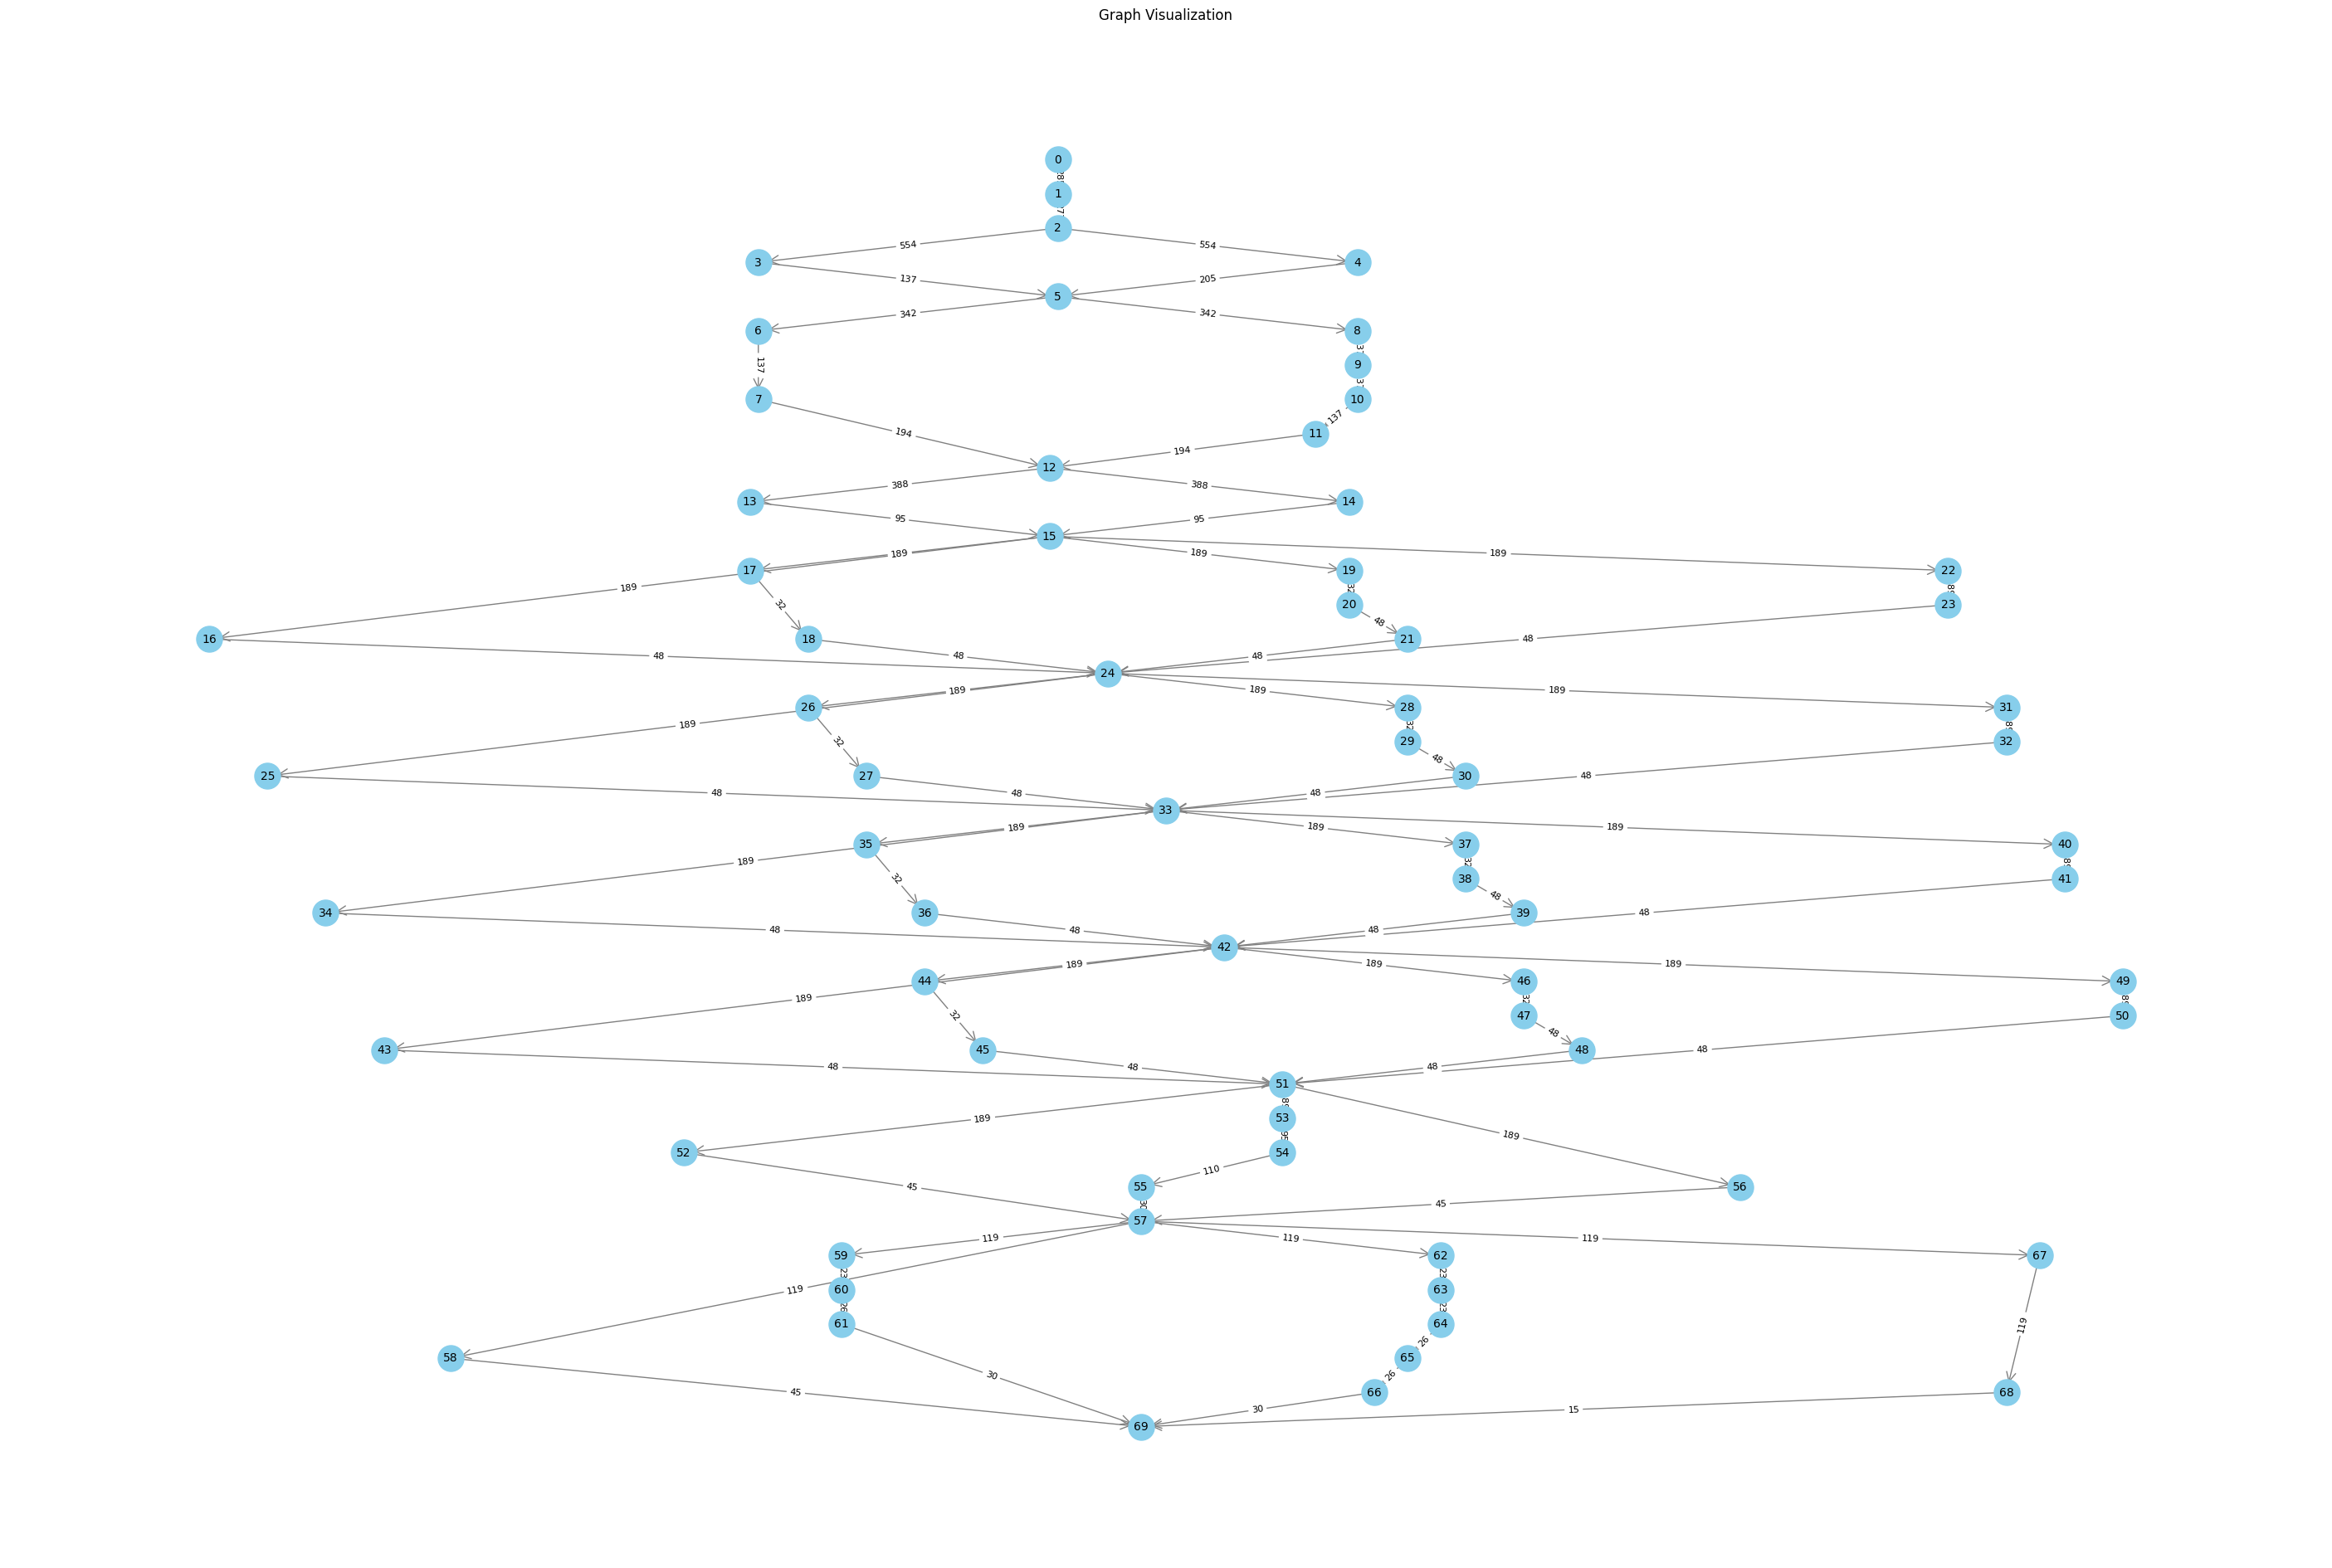

Set parameter Username
Set parameter LicenseID to value 2631888
Set parameter TimeLimit to value 1200
Set parameter LogFile to value "gurobi.log"
Set parameter Threads to value 20
Using license file /home/sfischer/Software/gurobi12.0.1_linux64/gurobi1201/gurobi.lic
Academic license - for non-commercial use only - expires 2026-03-06

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.2 LTS")
Copyright (c) 2025, Gurobi Optimization, LLC

Read LP format model from file /tmp/30b17f419b0f4284b398e37052664ac5-pulp.lp
Reading time = 0.07 seconds
OBJ: 123791 rows, 45084 columns, 334004 nonzeros

Using Gurobi shared library /home/sfischer/Software/gurobi12.0.1_linux64/gurobi1201/linux64/lib/libgurobi.so.12.0.1

CPU model: Intel(R) Core(TM) i7-14700KF, instruction set [SSE2|AVX|AVX2]
Thread count: 28 physical cores, 28 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  1200
Threads  20

Optimize a model with 123791 rows, 45084 columns and 334004

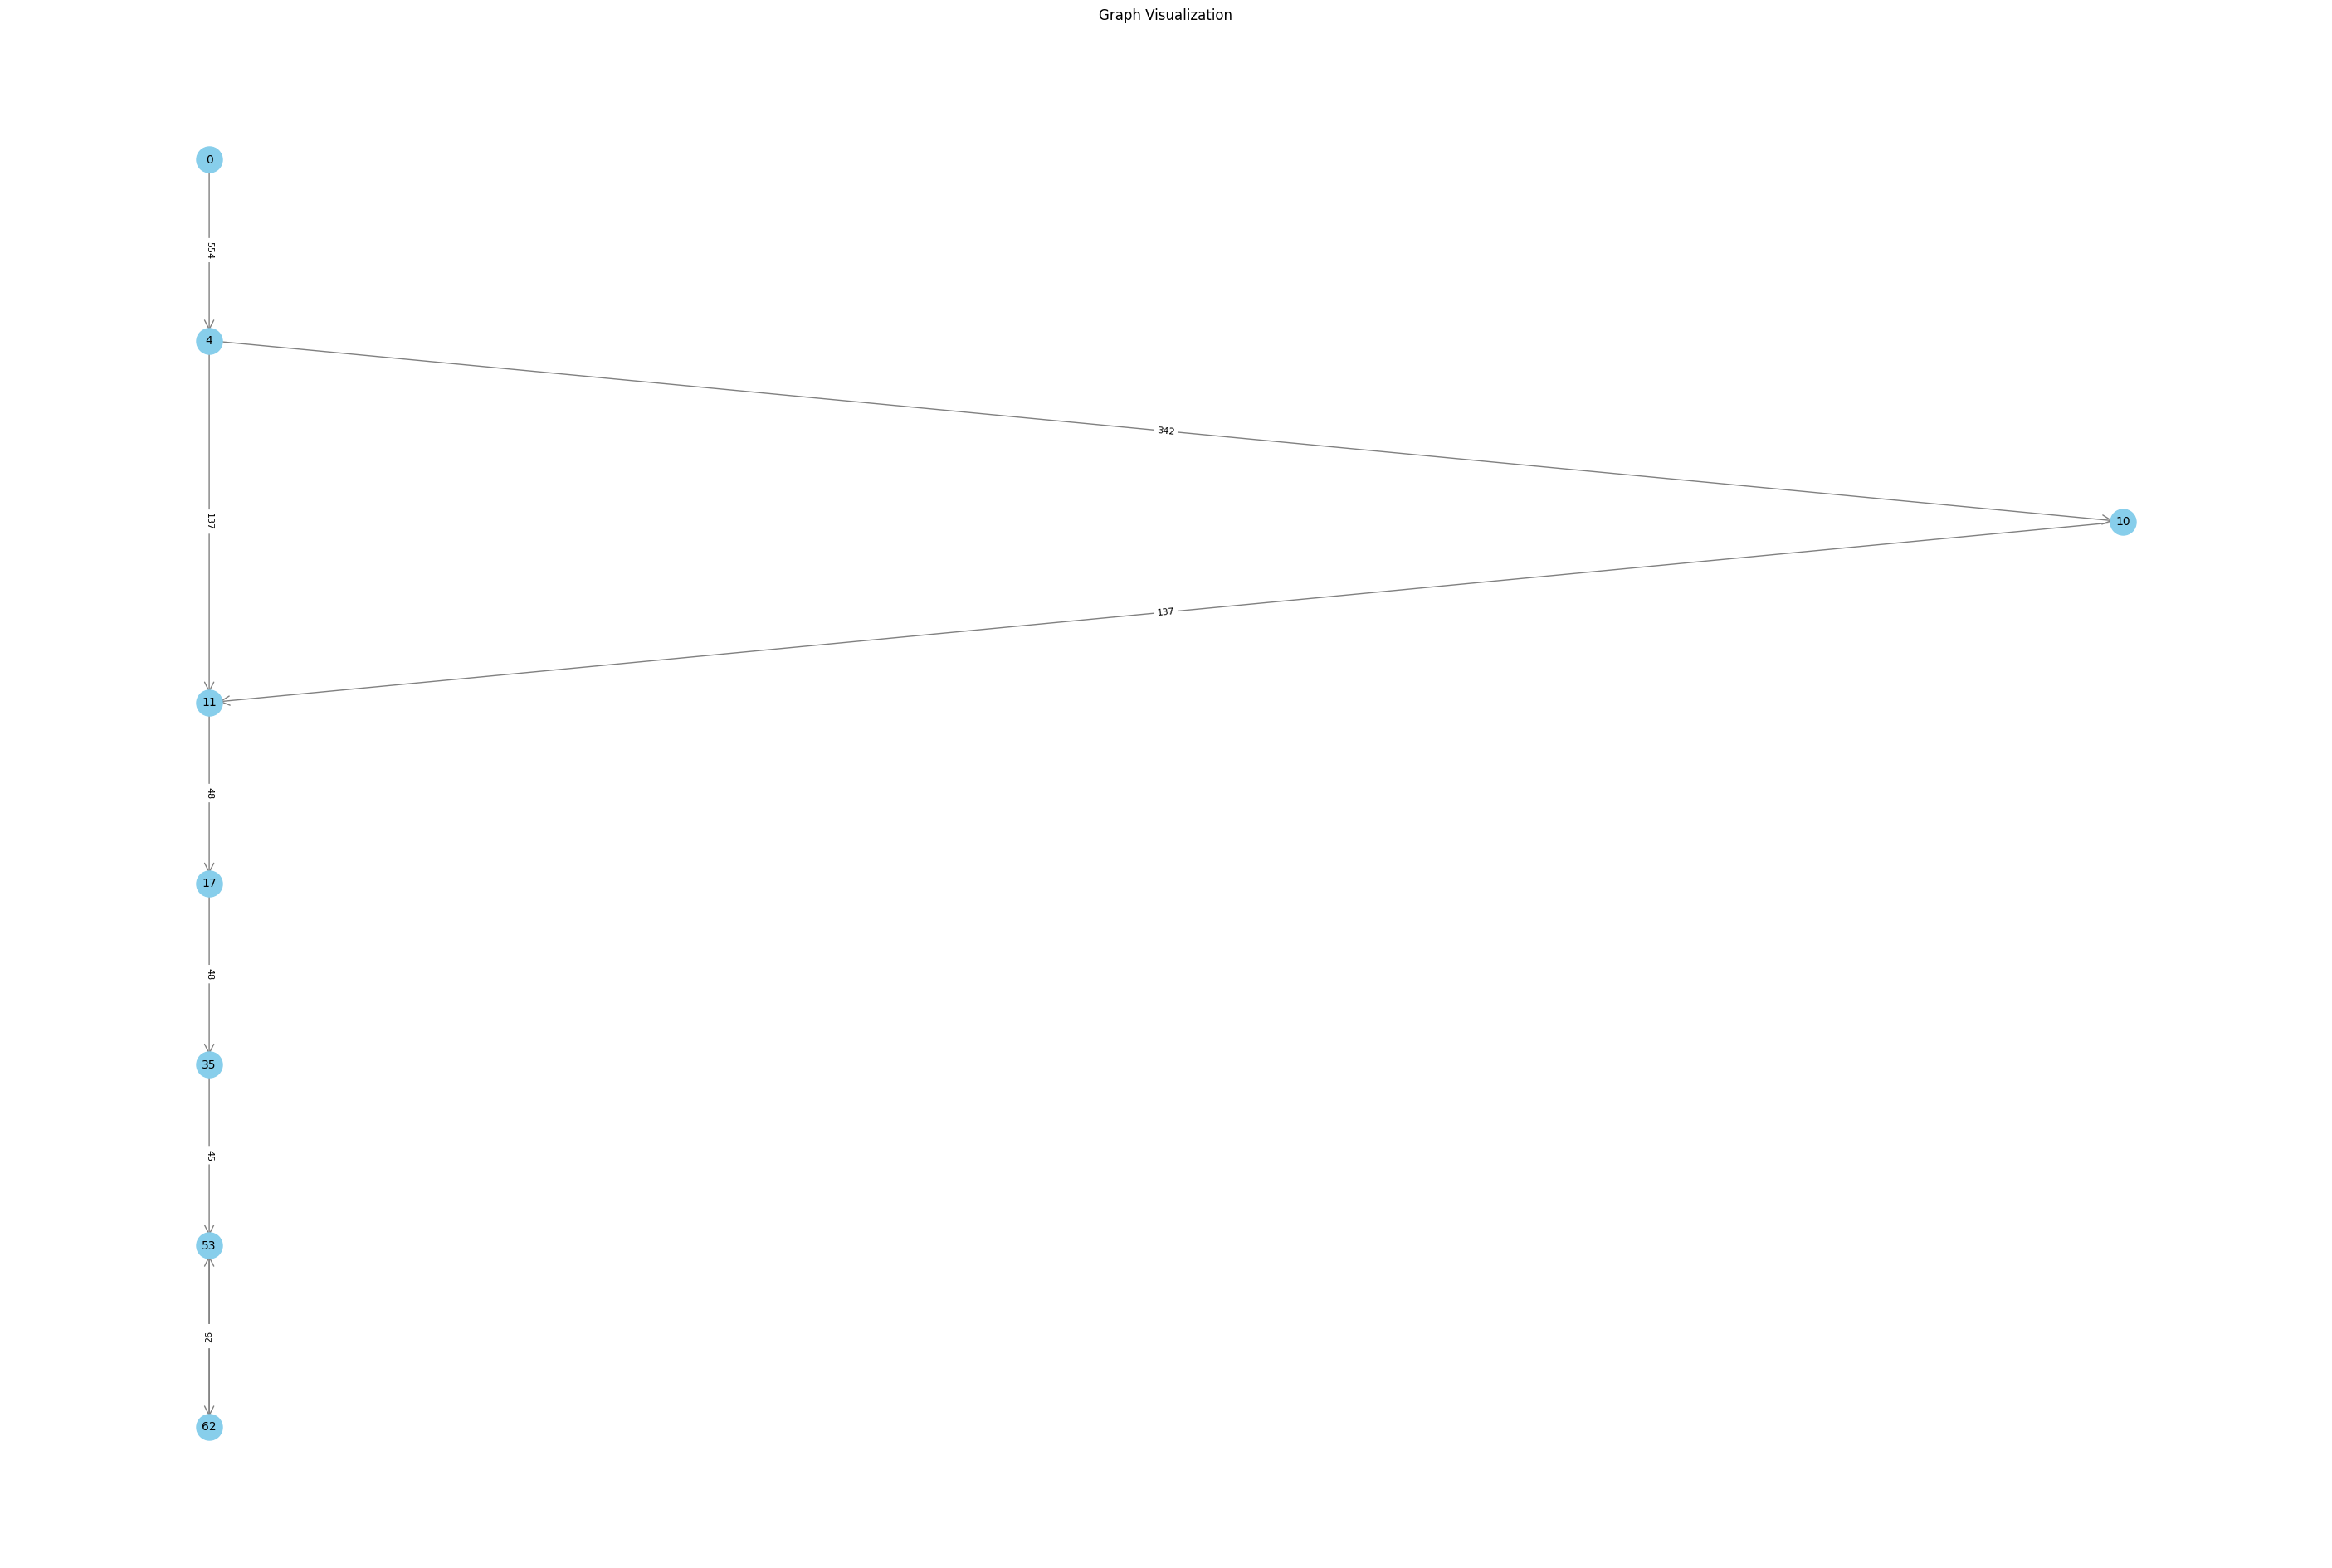

In [ ]:

def Graph2LinProgDynamicMap():
    import pulp
    import importlib
    import LinProg_lib
    importlib.reload(LinProg_lib)
    from LinProg_lib import draw_networkx_graph,combine_nodes
    # ======================================================================
    # Parameters of the NoC (how many PEs are available)
    # ======================================================================

    mesh_x=4
    mesh_y=4
    router_num=mesh_x*mesh_y

    noc_factor=param1
    comp_factor=param2
    # noc_factor=0.5
    # comp_factor=0.1



    # ======================================================================
    # Creating/importing the input Task graph 
    # ======================================================================
    
    # G = CreateNetworkXGraph(Figure=False,flit_delay_consistent=True,detailed=False)
    # G =CreateNetworkXGraphManuelParallel()

    G=CreateNetworkXGraph()


    for node, atr in G.nodes(data=True):
        G.nodes[node]['delay_send'] = math.ceil(atr['delay_send'] * noc_factor)
        G.nodes[node]['delay_comp'] = math.ceil(atr['delay_comp'] * comp_factor)


    for u, v, attrs in G.edges(data=True):
        print(f"Edge from {u} to {v}: {attrs}")


    for u, v, attrs in G.edges(data=True):
        G[u][v]['flits'] = math.ceil(attrs['flits'] * noc_factor)

    for u, v, attrs in G.edges(data=True):
        print(f"Edge from {u} to {v}: {attrs}")

    # Draw the graph
    plt.figure(figsize=(32, 14))
    pos = nx.spring_layout(G)  # Layout for positioning
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="black", arrows=True, node_size=800, font_size=12)

    # Draw edge labels (if any)
    edge_labels = {(u, v): f"{d.get('flits', '')}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title("NetworkX Graph Visualization")
    plt.show()
    # G.add_edge(7, 3, flits=10)
    # G.add_edge(7, 3, flits=10)
    draw_networkx_graph(G)
    
    # ======================================================================
    # Setup of LP model and initialization of variables
    # ======================================================================

    model = LpProblem(name='small-problem', sense=LpMinimize)
    
    task_vars = [{} for _ in G.nodes]
    task_total_delay_router = [{},{},{},{},{},{},{},{}] 
    task_total_delay_router = [{} for _ in range(router_num)]
    task_total_memory_router = [{},{},{},{},{},{},{},{}] 
    task_total_memory_router = [{} for _ in range(router_num)]

    PE_var = {}
    PE_delay = {}
    PE_delay_min = {}
    PE_delay_max = {}
    PE_mem = {}
    PE_partial = [{} for _ in range(router_num)]
    PE_mem_overflow = {}
    task_constraints = []  

    task_map={}

    same_map={}
    same_map_and={}


    # ======================================================================
    # Mapping variables of tasks (is this task mapped to this PE/router) 
    # ======================================================================
    for router in range(router_num):
        for task in G.nodes:
            if task not in task_map:
                task_map[task] = {}
            task_map[task][f"t_map_{router}"]=LpVariable(name=f't_{task}_map_{router}', cat="Binary")


    # for task in G.nodes:
    #     assigned_router = task // 5  # Integer division: 0-4→0, 5-9→1, etc.
    #     for router in range(router_num):
    #         if router == assigned_router:
    #             task_map[task][f"t_map_{router}"].setInitialValue(1)
    #             task_map[task][f"t_map_{router}"].fixValue()
    #         else:
    #             task_map[task][f"t_map_{router}"].setInitialValue(0)
    #             task_map[task][f"t_map_{router}"].fixValue()            

    # 5x optimal mapping
    manual_task_groups = [
        [0, 1, 2, 3],
        [10, 8, 9],
        [11, 12, 13, 14, 15, 16, 7],
        [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
        [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52],
        [4, 5, 6],
        [53, 54, 55, 56, 57, 58, 59, 60, 61, 65, 66, 67, 68, 69],
        [62, 63, 64]
    ]



    # manual_task_groups = [
    # list(range(0, 16)),    # 16 elements: 0-15
    # list(range(16, 20)),   # 4 elements: 16-19
    # list(range(20, 24)),   # 4 elements: 20-23
    # list(range(24, 28)),   # 4 elements: 24-27
    # list(range(28, 32)),   # 4 elements: 28-31
    # list(range(32, 36)),   # 4 elements: 32-35
    # list(range(36, 40)),   # 4 elements: 36-39
    # list(range(40, 44)),   # 4 elements: 40-43
    # list(range(44, 48)),   # 4 elements: 44-47
    # list(range(48, 52)),   # 4 elements: 48-51
    # list(range(52, 56)),   # 4 elements: 52-55
    # list(range(56, 60)),   # 4 elements: 56-59
    # list(range(60, 64)),   # 4 elements: 60-63
    # list(range(64, 68)),   # 4 elements: 64-67
    # list(range(68, 70)),   # 2-4 elements: 68-71 (adjust if you only want up to 70: use range(68, 71))
    # ]

    # Assign each group to a router index
    for router, task_group in enumerate(manual_task_groups):
        for task in G.nodes:
            if task in task_group:
                task_map[task][f"t_map_{router}"].setInitialValue(1)
                task_map[task][f"t_map_{router}"].fixValue()
            else:
                task_map[task][f"t_map_{router}"].setInitialValue(0)
                task_map[task][f"t_map_{router}"].fixValue()
    # # ======================================================================
    # Number of tasks per router
    # ======================================================================
    # for router in range(router_num):
    #     task_router_count = LpVariable(name=f'task_router_count_{router}', lowBound=0, cat="Integer")


    # for router in range(router_num):
    #     task_router_count = LpVariable(name=f'task_router_count_{router}', lowBound=0, cat="Integer")
    #     task_constraints.append(task_router_count >= lpSum(task_map[task][f"t_map_{router}"] for task in G.nodes))

    #     num_tasks = len(G.nodes)
    #     task_constraints.append(task_router_count <= math.ceil(num_tasks/16))

    #     print(f"max tasks per router: {math.ceil(num_tasks/16)}")


    # ======================================================================
    # Are two tasks mapped to the same PE/Router?
    # ======================================================================
    for task1 in G.nodes:
        for task2 in G.nodes:
            if task2>=task1:
                if task1 not in same_map:
                    same_map[task1] = {}
                
                if task1 not in same_map_and:
                    same_map_and[task1] = {}

                # bool: are task 1 and task 2 in the same creating variable
                same_map[task1][f"same_{task2}"]=LpVariable(name=f'same_{task1}_{task2}', cat="Binary")
                for same_and in range(router_num):
                    same_map_and[task1][f"same_{task2}_and_{same_and}"]=LpVariable(name=f'same_{task1}_{task2}_and_{same_and}', cat="Binary")

    # AND of task1_in_routerX and task2_in_routerX 
    for task1 in G.nodes:
        for task2 in G.nodes:
            if task2>task1:
                for same_and in range(router_num):
                    task_constraints.append(same_map_and[task1][f"same_{task2}_and_{same_and}"] <= task_map[task1][f"t_map_{same_and}"])
                    task_constraints.append(same_map_and[task1][f"same_{task2}_and_{same_and}"] <= task_map[task2][f"t_map_{same_and}"])
                    task_constraints.append(same_map_and[task1][f"same_{task2}_and_{same_and}"] >= task_map[task2][f"t_map_{same_and}"]+task_map[task1][f"t_map_{same_and}"]-1)

    # Combine all ANDs to check if two tasks are in the same PE/Router
    for task1 in G.nodes:
        for task2 in G.nodes:
            if task2 > task1:
                # OR condition: If any same_map_and[task1][task2]_X is 1, then same_map[task1][task2] must be 1 There should only be one and being one
                task_constraints.append(same_map[task1][f"same_{task2}"] == lpSum(same_map_and[task1][f"same_{task2}_and_{same_and}"] for same_and in range(router_num)))

            if task2==task1:
                task_constraints.append(same_map[task1][f"same_{task2}"] == 1)



    # ======================================================================
    # Constraints + dependencies of the task graph
    # ======================================================================

    t_send_list=[]
    # Define Variables and Constraints for each task
    for task in G.nodes:
        t_comp = LpVariable(name=f't_comp_{task}', lowBound=0)
        t_send = LpVariable(name=f't_send_{task}', lowBound=0)
        t_mem = LpVariable(name=f't_mem_{task}', lowBound=0)

        t_start = LpVariable(name=f't{task}_start', lowBound=0)
        t_end = LpVariable(name=f't{task}_end ', lowBound=0)
        t_send_list.append(t_send)
        task_vars[task] = {'t_start': t_start, 't_end': t_end, 't_comp': t_comp, 't_send': t_send, 't_mem': t_mem}

    for task, atr in G.nodes(data=True):

        # Every task can only be mapped to one router
        constraint = lpSum(task_map[task][f"t_map_{router}"] for router in range(router_num)) == 1
        task_constraints.append(constraint)

        predecessors = list(G.predecessors(task))


        # remove memory delay as it is saved in PE
        # task_constraints.append(task_vars[task]["t_start"] + task_vars[task]["t_comp"] <= task_vars[task]["t_end"])
        task_constraints.append(task_vars[task]["t_start"] + task_vars[task]["t_comp"] +task_vars[task]['t_send'] <= task_vars[task]["t_end"])

        # Predecessor constraints
        for pre in predecessors:
            # task_constraints.append(task_vars[pre]['t_end'] + task_vars[pre]['t_send'] <= task_vars[task]["t_start"])
            task_constraints.append(task_vars[pre]['t_end']<= task_vars[task]["t_start"])
        # Constraint for first task
        if task==0:
            # remove memory delay as it is saved in PE
            # model += task_vars[rep][0]['t_comp'] + task_vars[rep][0]['t_mem'] <= task_vars[rep][0]['tR0_end']
            model += task_vars[0]['t_comp'] <= task_vars[0]['t_end']
            model += 0 <= task_vars[0]['t_start']

        # Static time constraints
        task_constraints.append(task_vars[task]["t_comp"] == atr['delay_comp'])
        task_constraints.append(task_vars[task]["t_mem"] == atr['delay_mem'])

    #total t_send
    t_send_total = LpVariable(name=f't_send_total', lowBound=0)
    # task_constraints.append(t_send_total<=110)
    task_constraints.append(t_send_total >= lpSum(t_send_list))

    M = 25e4


    # ======================================================================
    # If the successor of a task is in the same PE the sending delay is 0/the normal sending delay condition does not apply
    # ======================================================================
    time_per_flit=0.649
    for task, atr in G.nodes(data=True):
        successors = list(G.successors(task))
        if successors:
            task_constraints.append(task_vars[task]['t_send'] >= 0)
            task_constraints.append(task_vars[task]['t_send'] +M*(same_map[task][f"same_{successors[0]}"])>= math.ceil(atr['delay_send']*time_per_flit))


    # ======================================================================
    # Only one task can execute in one PE at the same time. If tasks are dependent on each other this is automatically satisfied
    # ======================================================================
    nodes = list(G.nodes)
    for i, task1 in enumerate(nodes):
        for task2 in nodes[i+1:]:
            if (not(nx.has_path(G, task1, task2) or nx.has_path(G, task2,task1))):

                
                # task1_idx, task1_rep = map(int, task1.split('_'))
                # task2_idx, task2_rep = map(int, task2.split('_'))

                if f"same_{task1}" in same_map[task2]:
                    temp=same_map[task2][f"same_{task1}"]
                elif f"same_{task2}" in same_map[task1]:
                    temp=same_map[task1][f"same_{task2}"]
                else:
                    print(task1,task2)
                    print("NO combinatnion exists")

                order_choose_var=LpVariable(name=f'order_choose_{task1}_{task2}', cat="Binary")
                task_constraints.append(task_vars[task1]['t_end'] <= task_vars[task2]['t_start']+ M*(1-order_choose_var) + M*(1-temp))
                task_constraints.append(task_vars[task2]['t_end'] <= task_vars[task1]['t_start']+ M*(order_choose_var) + M*(1-temp))


    # ======================================================================
    # Add memory constraints: if memory exceeds the PE capacity, add delay because memory must be fetched from main mem
    # ======================================================================

    # Get the usage time of each PE
    max_router_delay=LpVariable(name=f'max_router_delay', lowBound=0)
    max_memory_overflow=LpVariable(name=f'max_memory_overflow', lowBound=0)

    # max_memory=200 #bytes
    max_memory=0 #bytes
    delay_per_flit_mem=0
    for router in range(router_num):
        PE_var[router]=LpVariable(name=f'PE{router}_total_delay', lowBound=0)
        PE_mem_overflow[router]=LpVariable(name=f'PE_mem_overflow{router}', lowBound=0)
        
        PE_mem[router]=LpVariable(name=f'PE{router}_total_memory', lowBound=0)

        sum_list=[]
        sum_list_mem=[]
        for task in G.nodes:
            task= int(task)
            # task_idx, task_rep = map(int, task.split('_'))
            task_total_delay_router[router][task]=LpVariable(name=f'task_total_delay_router_router{router}_task{task}', lowBound=0)
            task_constraints.append(task_total_delay_router[router][task]>=task_vars[task]['t_end']-task_vars[task]['t_start']+task_vars[task]['t_send'] - M*(1-task_map[task][f"t_map_{router}"]))
            sum_list.append(task_total_delay_router[router][task])

            task_total_memory_router[router][task]=LpVariable(name=f'task_total_memory_router_router{router}_task{task}', lowBound=0)
            task_constraints.append(task_total_memory_router[router][task]>=task_vars[task]['t_mem'] - M*(1-task_map[task][f"t_map_{router}"]))
            sum_list_mem.append(task_total_memory_router[router][task])
            PE_partial[router][task]=list(sum_list_mem)
        task_constraints.append(PE_mem_overflow[router]>=lpSum(sum_list_mem) -max_memory)

        # task_constraints.append(PE_mem_overflow[router]>=lpSum(sum_list_mem))


        task_constraints.append(PE_var[router] >= lpSum(sum_list) + PE_mem_overflow[router]*delay_per_flit_mem) #total delay per router
        # task_constraints.append(PE_var[router] >= lpSum(sum_list)) #total delay per router no memory
        task_constraints.append(PE_mem[router] >= lpSum(sum_list_mem)) #total memory per router


        task_constraints.append(max_memory_overflow>=PE_mem_overflow[router]) #max memory overflow per router

        # task_constraints.append(PE_mem_overflow[router]<=5311.0) # calculated as max memory overflow
        



        # task_constraints.append(max_router_delay>=PE_var[router])
        
        # enforce optimal PE delay
        # task_constraints.append(PE_var[router] <= 1010)  # Slightly stricter bound

        # PE_var[router].bounds(0, 3248) # Set the max delay per router to the optimal one
        # PE_var[router].bounds(0, 3250) # Set the max delay per router to the optimal one
        # PE_mem[router].bounds(0, 20) # Set the max memory per router to a random number

        

        # ======================================================================
        # optimization goal for max throughput is to minimize the max delay(start-end time of all tasks) of the router/PE
        # ======================================================================
        # make throughput max-min not sum(delays)

        PE_delay[router]=LpVariable(name=f'PE{router}_total_time_delay', lowBound=0)
        PE_delay_min[router]=LpVariable(name=f'PE{router}_time_delay_min', lowBound=0)
        PE_delay_max[router]=LpVariable(name=f'PE{router}_time_delay_max', lowBound=0)

        for i, task1 in enumerate(nodes):
            # task_vars[task1]['t_end'] <= task_vars[task2]['t_start']
            # task_vars[task]['t_mem'] - M*(1-task_map[task][f"t_map_{router}"])
            

            ## ADDED THE OVEFRFLOW HERE
            task_constraints.append(PE_delay_max[router]>=task_vars[task1]['t_end'] - M*(1-task_map[task1][f"t_map_{router}"])+PE_mem_overflow[router]*delay_per_flit_mem)
            task_constraints.append(PE_delay_min[router]<=task_vars[task1]['t_start'] + M*(1-task_map[task1][f"t_map_{router}"]))

        task_constraints.append(PE_delay[router]==PE_delay_max[router]-PE_delay_min[router])


        # max router delay is now dependent on the actual time (max-min) of the tasks in the PE
        task_constraints.append(max_router_delay>=PE_delay[router])

        # task_constraints.append(PE_delay[router] <= 1943*1) #strictly enforce some/optimal delay/throughput 2096
        # task_constraints.append(PE_delay[router] <= 2096*1.2) #strictly enforce some/optimal delay/throughput

        # task_constraints.append(PE_delay[router] <= 4098*1) #34 layers inception 
        # task_constraints.append(PE_delay[router] <= 7725*1) #94 layers inception 
        # task_constraints.append(PE_delay[router] <= 4683*1) #94 layers inception reduced add

        # task_constraints.append(PE_delay[router] <= 4016*1) #6 layers inception 

        # task_constraints.append(PE_delay[router] <= 2247*1.001) #52 layers inception 
        # task_constraints.append(PE_delay[router] <= 2697*1.01) #70 layers inception  
        # task_constraints.append(PE_delay[router] <= 862*1) #70 layers inception fast gemmini 
        # task_constraints.append(PE_delay[router] <= 6009*1) #70 layers inception fast gemmini and memory with zero size 
        # task_constraints.append(PE_delay[router] <= 5633*1) #70 layers inception fast gemmini and memory with zero size 
        # task_constraints.append(PE_delay[router] <= 613*1) #70 layers inception fast gemmini and no memory
        
        # task_constraints.append(PE_delay[router] <= 10590) #all layers inception 

        # task_constraints.append(PE_delay[router] <= 20615) #all layers inception 

        # task_constraints.append(PE_delay[router] <=  243) 
        




    # ======================================================================
    # Add constraints to the model
    # ======================================================================

    for constraint in task_constraints:
        model += constraint

    # ======================================================================
    # Set the objective function and solve the model
    # ======================================================================

    # Objective function
    # model += task_vars[18]['t_end']
    model += max_router_delay

    #optimize: minimize the traffic I have by minimizing t_send_total while having optimal time per PE
    # model+=t_send_total
    # exit()
    # # Solve the problem
    # status = model.solve(PULP_CBC_CMD(threads=20))


    # model += max_memory_overflow  # Minimize the memory per router

    status = model.solve(pulp.GUROBI_CMD(threads=20, timeLimit=1200))
    
    # ======================================================================
    # print debug information
    # ======================================================================
    # G=combine_nodes(G, 8, 14,14)
    

    print(f"objective: {model.objective.value()}")

    import os
    import pickle
    import csv
    
    # Set your subfolder and filename here
    subfolder = "inception70/Opt_noChange_5x_fasterLink"
    filename = f"No_mem_opt_5x_NoC{noc_factor}_Comp{comp_factor}.pkl"

    # Create the full path
    results_dir = f"/home/sfischer/Documents/projects/wk_LinProg/optimization_results/{subfolder}"
    os.makedirs(results_dir, exist_ok=True)  # Create subfolder if it doesn't exist

    # Save the model
    with open(os.path.join(results_dir, filename), "wb") as f:
        pickle.dump(model, f)




    with open("Task_graph.pkl", "wb") as f:
        pickle.dump(G, f)

    nx.write_graphml(G, "Task_graph.graphml")


    csv_path = os.path.join(results_dir, "resultsLinProg.csv")
    row = [noc_factor, comp_factor, model.objective.value()]
    write_header = not os.path.exists(csv_path)
    with open(csv_path, mode='a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if write_header:
            writer.writerow(["noc_factor", "comp_factor", "objective_value"])
        writer.writerow(row)


    # Combine nodes and create a new graph + graph figure
    import re
    mappings = {}

    for v in model.variables():

        match = re.match(r't_(\d+)_map_(\d+)\s*=\s*(\d+\.\d+)', f"{v.name} = {v.varValue}\n")
        if match:
            task, pe, value = match.groups()
            if float(value) > 0.9 and float(value) < 1.1:
                pe = int(pe)
                if pe not in mappings:
                    mappings[pe] = []
                mappings[pe].append(int(task))


    with open("CombinedMapping.txt", "w") as f:
        for router, tasks in mappings.items():
            f.write(f"Router {tasks[0]}: Tasks {tasks}\n")
    for router, tasks in mappings.items():
        for task in tasks:
            if task != tasks[0]:
                G=combine_nodes(G, tasks[0], task,tasks[0])

    print(G.edges)
    draw_networkx_graph(G)

    

    with open("PE_graph.pkl", "wb") as f:
        pickle.dump(G, f)

    nx.write_graphml(G, "PE_graph.graphml")

    

    # for task in G.nodes:
    #     for router in range(router_num):
    #         var_name = f't_{task}_map_{router}'
    #         var_value = task_map[task][f"t_map_{router}"].varValue
    #         if float(var_value) > 0.7 and float(var_value) < 1.3: # Check if the task is mapped to this router
    #             mapped_tasks_per_router[router].append(task)

    # # Print the results
    # for router, tasks in mapped_tasks_per_router.items():
    #     print(f"Router {router}: Tasks {tasks}")
    # # # Open a file to write the variable values
    # with open("/home/sfischer/Documents/projects/wk_hybridNoC_VHDL/Python/gen_vhdl_from_task/temp.txt", "w") as f:
    #     for v in model.variables():
    #         f.write(f"{v.name} = {v.varValue}\n")

    #     f.write("\nConstraints:\n")
        
    #     # Print all constraints in their final form
    #     for name, constraint in model.constraints.items():
    #         f.write(f"{name}: {constraint}\n")
    # print(f"Solver Status: {LpStatus[model.status]}")

    # # # Print the start and end times of all tasks
    # # for rep in range(repetitions):
    # #     print(f"Repetition {rep}:")
    # for task in G.nodes:
    #     start_time = task_vars[task]['t_start'].varValue
    #     end_time = task_vars[task]['t_end'].varValue
    #     print(f"Task {task}: Start Time = {start_time}, End Time = {end_time}")
    # print(f"Max Router Delay: {max_router_delay.varValue}")

    # # Print the total delay for each PE
    # for router in range(len(PE_delay)):
    #     print(f"PE {router} Total Delay: {PE_delay[router].varValue}")
    #     print(f"PE {router} Max Delay: {PE_delay_max[router].varValue}")
    #     print(f"PE {router} Min Delay: {PE_delay_min[router].varValue}")
    #     # for i, task1 in enumerate(nodes):
    # print(f"Total t_send: {t_send_total.varValue}")


if __name__ == "__main__":
    Graph2LinProgDynamicMap()